# Regression Project - Yelin

In [957]:
# Data Cleaning and Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.impute import SimpleImputer

# Regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV, LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from scipy.spatial import KDTree

## Summary of Work Flow

### Model 1
`rent_org` -> `rent_v1`: Data is cleaned to make sure there is no missing values except for `sq_feet`. Manipulation of entries with `type` == `Room For Rent` is performed. See detail in EDA and Data Peparation section. 

`rent_v1` -> `rent_imputed_beds`: `sq_feet_num` is created to correct the format issue in `sq_feet` and fill in the missing data.

`rent_v1` -> `rent_v3`: Data is encoded using `encoding()`. `rent_v3` is used to train and test `Lasso` and `Ridge` model. 

`Lasso` and `Ridge` are tested 10 times using `modeling()`. The performance metrics are stored in `model1a_metrics` and `model1b_metrics`, and the average of performance metrics are evaluated. 

### Model 1 Modified, dropped outliers
`rent_imputed_beds` -> `rent_v4`: Droped selected `type`, log transformation to `sq_feet_num`

`rent_v4` -> `rent_v5`: Data is encoded using `encoding()`. `rent_v5` is used to train and test `Lasso` and `Ridge` model.

`Lasso` and `Ridge` are tested 10 times using `modeling()`. The performance metrics are stored in `model1a_metrics_m` and `model1b_metrics_m`, and the average of performance metrics are evaluated. 

### Model 2 - Creation of interaction term and dropped outliers
`rent_v4` is further modified prior to the creation of the second model: 
1. Interaction terms of `bedroom/sqsft` and `bathroom/sqft` is added.
2. `price/sqft` is created.

`rent_v4` -> `rent_v6`: Extreme outliers in `price/sqft` is dropped.

`rent_v6` -> `rent_v7`: Data is encoded using `encoding()`. `rent_v7` is used to train and test `Lasso` and `Ridge` model. 

`Lasso` and `Ridge` are tested 10 times using `modeling2()`. The performance metrics are stored in `model2_metrics` and `model2_metrics`, and the average of performance metrics are evaluated. 

### Model 3 - Creation of zipcode index
`rent_v6` -> `rent_v8`: `postcode` and `postcode_index` are creted based on the mapping of `longitude` and `latitude`, and the group average of `price/sqft`.

`rent_v8` -> `rent_v9`: Data is encoded using `encoding_v3()`. `rent_v8` is used to train and test `Lasso` and `Ridge` model.

`Lasso` and `Ridge` are tested 10 times using `modeling()`. The performance metrics are stored in `model3_metrics` and `model3_metrics`, and the average of performance metrics are evaluated. 


### Functions
`encoding()` -> `encoding_v3`: Extra columns are encoded due to the creation of `postcode_index`.
`modeling()` -> `modeling2()`: Extra columns are scaled due to the creation of features from `rent_v4` -> `rent_v6`.

## EDA and Data Preparation

In [958]:
# Import data
rent_org = pd.read_csv('canada_rent.csv')
rent_org.sample(5)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
20792,542010,Toronto,Ontario,3464 Yonge St,43.734946,-79.404881,Long Term,Apartment,2200.0,1 Bed,1,600,/on/toronto/rentals/apartment/1-bedroom/542010,Unfurnished,Immediate,NaN,False,False
13419,327463,Calgary,Alberta,2409 28 Street Southwest,51.032736,-114.128386,Long Term,Townhouse,1850.0,2 Beds,1,1000,/ab/calgary/rentals/townhouse/2-bedrooms/killa...,Unfurnished,August 01,Non-Smoking,False,False
13342,473182,Calgary,Alberta,1140 15th Ave SW,51.039530,-114.088654,Long Term,Condo Unit,2450.0,2 Beds,1.5,894,/ab/calgary/rentals/condo/2-bedrooms/beltline/...,Furnished,August 01,Non-Smoking,False,False
13217,571898,Calgary,Alberta,707 - 550 Riverfront Avenue SE,51.044733,-114.071883,Long Term,Apartment,2600.0,1 Bed,1.5,665,/ab/calgary/rentals/apartment/1-bedroom/downto...,Unfurnished,July 09,Non-Smoking,False,False
3765,570071,Calgary,Alberta,1540 29 St NW,51.065740,-114.129630,Long Term,Room For Rent,900.0,3 Beds,1,NaN,/ab/calgary/rentals/shared/3-bedrooms/st-andre...,Furnished,July 01,Non-Smoking,False,False


In [959]:
rent_org.info() # 25771 * 17, with null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

### Summary
Points to watch:

- The dataset contains **NULL** value. This needs to be handled
- `city`, `province`, `address`, `latitude`, `longitude` encode similar information - can drop some columns based on further analysis
- `lease_term`, `type`, `furnishing`, `smoking`, `cats`, `dogs` are categorical data - needs to be encoded
- `sq_feet`, `beds`, `baths` should be numeric - needs to be converted into int|float
- `rentfaster_id`, `link`, `availability_date` can be dropped
- `price` as the target variable needs to be further explroed
- There are duplicates found when investigating the dataset accidentally - needs to be dropped

### Data Exploration

Text(0.5, 1.0, 'Price Distribution, >10000')

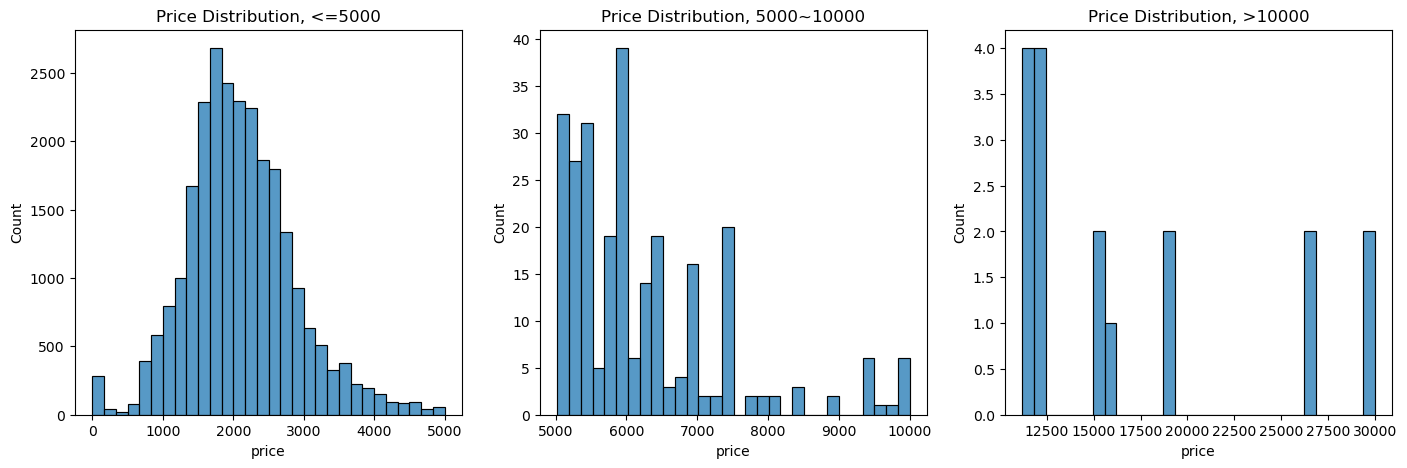

In [960]:
# Distribution in price
fig1, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(17,5))

sns.histplot(ax=ax1, data=rent_org[rent_org['price']<=5000], x='price', bins=30)
ax1.set_title("Price Distribution, <=5000")

sns.histplot(ax=ax2, data=rent_org[(rent_org['price']>5000)&(rent_org['price']<=10000)], x='price', bins=30)
ax2.set_title("Price Distribution, 5000~10000")

sns.histplot(ax=ax3, data=rent_org[rent_org['price']>10000], x='price', bins=30)
ax3.set_title("Price Distribution, >10000")

Visualization of price distribution showed that:

- There are certain properties with the rent price of 0.0 - consider to drop because the data is invalid

- There are also properties with significant high rent price - consider to handle

In [961]:
# Drop where price == 0 
rent_v1 = rent_org.drop(rent_org[rent_org['price']==0].index)
rent_v1.shape # Pass

(25544, 18)

In [962]:
# Drop duplicates
rent_v1.drop(columns=['rentfaster_id'],inplace=True)
rent_v1 = rent_v1.drop_duplicates()
rent_v1.shape

(18947, 17)

### Missing Value Exploration

In [963]:
# Pull out columns containing null values
def get_null_col(df):
    return df.isna().any()[df.isna().any()]

get_null_col(rent_v1) 

address              True
lease_term           True
beds                 True
baths                True
sq_feet              True
availability_date    True
smoking              True
cats                 True
dogs                 True
dtype: bool

#### address
Consider to drop the entire column of address becaue latitude and longitude can give the same information.

#### lease_term

In [964]:
# Check unique values in lease Term
rent_v1['lease_term'].value_counts()

Long Term     17726
Negotiable      903
Short Term      222
12 months        62
6 months          2
months            1
Name: lease_term, dtype: int64

In [965]:
# Chrck null value in lease term
rent_v1[rent_v1['lease_term'].isna()].shape

(31, 17)

Consider to drop where `lease_term` == NA , as most of the rows have `sq_feet` == NA and missing value is small proportion (~0.1%).

#### sq_feet

In [966]:
rent_v1[rent_v1['sq_feet'].isna()].shape

(2917, 17)

Consider to impute missing values in `sq_feet` by:
1. group by `type` and/or `beds` and `baths`, fill in average `sq_feet`

OR

2. make a multiple regression modeel based on `beds`, `baths`, and/or `type`

#### beds and baths

In [967]:
rent_v1[rent_v1['beds'].isna()].sample(5)

,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
8519,Red Deer,Alberta,5029 34 Street,52.255015,-113.859991,Long Term,Parking Spot,575.0,NaN,NaN,NaN,/ab/red-deer/rentals/parking-spot/south-hill/n...,Unfurnished,Immediate,Non-Smoking,NaN,NaN
3144,Calgary,Alberta,112 14 Avenue Southeast,51.039699,-114.062609,Negotiable,Parking Spot,250.0,NaN,NaN,NaN,/ab/calgary/rentals/parking-spot/victoria-park...,Unfurnished,July 01,Non-Smoking,NaN,NaN
11296,Calgary,Alberta,210 15 Avenue Southeast,51.038829,-114.060384,Long Term,Parking Spot,240.0,NaN,NaN,NaN,/ab/calgary/rentals/parking-spot/victoria-park...,Unfurnished,Immediate,Non-Smoking,NaN,NaN
10940,Calgary,Alberta,1212 1 Street Southeast,51.040658,-114.060370,Negotiable,Office Space,800.0,NaN,NaN,NaN,/ab/calgary/rentals/office-space/victoria-park...,Unfurnished,Immediate,Non-Smoking,NaN,NaN
2474,Calgary,Alberta,5964 Centre Street South,50.999645,-114.063610,Negotiable,Office Space,1100.0,NaN,NaN,NaN,/ab/calgary/rentals/office-space/manchester/no...,Unfurnished,Immediate,Non-Smoking,NaN,NaN


Note that for most of the cases where `beds` is NA, `baths` and `sq_fee`t are also NA

In [968]:
# Check
rent_v1[rent_v1['beds'].isna()].shape,\
rent_v1[(rent_v1['baths'].isna())&(rent_v1['beds'].isna())&(rent_v1['sq_feet'].isna())].shape,\
rent_v1[rent_v1['baths'].isna()].shape,\
rent_v1[(rent_v1['baths'].isna())&(rent_v1['sq_feet'].isna())].shape

((66, 17), (65, 17), (67, 17), (65, 17))

Consider to drop where `beds` or `bath` is NA, because most of `beds` NA have `baths` and `sq_feet` missing. The proportion of missing value is small (~0.3%).

#### smoking

In [969]:
rent_v1[rent_v1['smoking'].isna()].shape

(2323, 17)

In [970]:
rent_v1['smoking'].value_counts()

Non-Smoking            16147
Smoke Free Building      278
Smoking Allowed          142
Negotiable                57
Name: smoking, dtype: int64

Consider to fill in missing values in `smoking` with its mode ('non-smoking').

#### cats/dogs

In [971]:
rent_v1[rent_v1['cats'].isna()].shape,\
rent_v1[rent_v1['dogs'].isna()].shape,\
rent_v1[(rent_v1['cats'].isna())&(rent_v1['dogs'].isna())].shape

((100, 17), (100, 17), (100, 17))

In [972]:
rent_v1['cats'].value_counts()

True     12819
False     6028
Name: cats, dtype: int64

In [973]:
rent_v1['dogs'].value_counts()

True     12271
False     6576
Name: dogs, dtype: int64

Consider to drop the missing values in `cats` or `dogs` as the proportion is small (~0.5%)

### Missing Value handling - Except sq_feet
1. Drop the entire column of `address` as there are other features that provide similar information.
2. Drop rows with NA values in `lease_term`, `beds`,`baths`,`cats`,`dogs`.
3. Fill missing values in `smiking` with its mode.
4. Due to the challenge of handling missing value in `sq_feet`, the encoding of categorical variables are needed beforehand.

In [974]:
# Drop columns: address, link, availability_date
rent_v1.drop(columns=['address','link','availability_date'],inplace=True)

In [975]:
# Drop NA rows in lease term, beds, baths, cats, dogs
rent_v1.drop(rent_v1[rent_v1['lease_term'].isna()].index, inplace=True)
rent_v1.drop(rent_v1[rent_v1['baths'].isna()].index, inplace=True)
rent_v1.drop(rent_v1[rent_v1['beds'].isna()].index, inplace=True)
rent_v1.drop((rent_v1[(rent_v1['cats']).isna()&(rent_v1['dogs']).isna()]).index, inplace=True)
rent_v1.shape

(18815, 14)

In [976]:
# Impute smoking
imputer_cat = SimpleImputer(strategy='most_frequent')
rent_v1['smoking'] = imputer_cat.fit_transform(pd.DataFrame(rent_v1['smoking']))
rent_v1['smoking'].value_counts() # Pass

Non-Smoking            18339
Smoke Free Building      278
Smoking Allowed          142
Negotiable                56
Name: smoking, dtype: int64

In [977]:
# Sanity check
get_null_col(rent_v1) 

sq_feet    True
dtype: bool

### Encoding Categorical Data

#### lease_term

In [978]:
rent_v1['lease_term'].value_counts()

Long Term     17658
Negotiable      871
Short Term      221
12 months        62
6 months          2
months            1
Name: lease_term, dtype: int64

In [979]:
# Merge 12 months into Long-Term; months and 6 into Short Term.
rent_v1.loc[(rent_v1['lease_term']=='Long Term')|(rent_v1['lease_term']=='12 months'), 'lease_term_1']='Long Term'
rent_v1.loc[(rent_v1['lease_term']=='Short Term')|(rent_v1['lease_term']=='months')|(rent_v1['lease_term']=='6 months'), 'lease_term_1']='Short Term'
rent_v1.loc[(rent_v1['lease_term']=='Negotiable'), 'lease_term_1']='Negotiable'
rent_v1.drop(columns=['lease_term'],inplace=True)
rent_v1['lease_term_1'].value_counts()

Long Term     17720
Negotiable      871
Short Term      224
Name: lease_term_1, dtype: int64

#### Furnishing

In [980]:
rent_v1['furnishing'].value_counts()

Unfurnished                17196
Furnished                   1374
Negotiable                   242
Unfurnished, Negotiable        3
Name: furnishing, dtype: int64

In [981]:
# Combine unfurnished, negotiable into negotiable
rent_v1.loc[(rent_v1['furnishing']=='Unfurnished'), 'furnishing_1']='Unfurnished'
rent_v1.loc[(rent_v1['furnishing']=='Negotiable')|(rent_v1['furnishing']=='Unfurnished, Negotiable'), 'furnishing_1']='Negotiable'
rent_v1.loc[(rent_v1['furnishing']=='Furnished'), 'furnishing_1']='Furnished'
rent_v1.drop(columns=['furnishing'],inplace=True)
rent_v1['furnishing_1'].value_counts()

Unfurnished    17196
Furnished       1374
Negotiable       245
Name: furnishing_1, dtype: int64

#### beds/baths

In [982]:
# beds
rent_v1['beds'].value_counts()

2 Beds    7205
1 Bed     7054
3 Beds    2552
Studio    1334
4 Beds     482
5 Beds     140
6 Beds      35
7 Beds       8
9 Beds       3
8 Beds       2
Name: beds, dtype: int64

In [983]:
# Convert Studio to 0 Bed
rent_v1.loc[(rent_v1['beds']=='Studio'), 'beds']='0 Beds'
rent_v1['beds'].value_counts()

# Transform to integer
rent_v1['beds']=rent_v1['beds'].str[0].astype('int')

# Check
rent_v1['beds'].value_counts() # Pass

2    7205
1    7054
3    2552
0    1334
4     482
5     140
6      35
7       8
9       3
8       2
Name: beds, dtype: int64

In [984]:
# Baths
rent_v1['baths'].value_counts()

1       12715
2        3605
2.5      1202
1.5       692
3.5       253
3         249
4          58
4.5        14
none        8
5           7
5.5         3
6           2
7           2
0           2
7.5         1
6.5         1
8           1
Name: baths, dtype: int64

In [985]:
# Convert none to 0
rent_v1.loc[(rent_v1['baths']=='none'), 'baths']='0'
rent_v1['baths'].value_counts()

# Transform to integer
rent_v1['baths']=rent_v1['baths'].astype('float')

# Check
rent_v1['baths'].value_counts() # Pass

1.0    12715
2.0     3605
2.5     1202
1.5      692
3.5      253
3.0      249
4.0       58
4.5       14
0.0       10
5.0        7
5.5        3
6.0        2
7.0        2
7.5        1
6.5        1
8.0        1
Name: baths, dtype: int64

#### Smoking


In [986]:
rent_v1['smoking'].value_counts()

Non-Smoking            18339
Smoke Free Building      278
Smoking Allowed          142
Negotiable                56
Name: smoking, dtype: int64

In [987]:
# Put Smoking Free buikding and Non-Smoking together
rent_v1.loc[(rent_v1['smoking']=='Smoke Free Building'), 'smoking']='Non-Smoking'

# Check
rent_v1['smoking'].value_counts() # Pass

Non-Smoking        18617
Smoking Allowed      142
Negotiable            56
Name: smoking, dtype: int64

#### type

In [988]:
rent_v1['type'].value_counts() # Pass

Apartment        13200
Condo Unit        1306
Townhouse         1050
House             1027
Basement          1017
Main Floor         468
Room For Rent      410
Duplex             310
Loft                15
Acreage              8
Vacation Home        2
Mobile               2
Name: type, dtype: int64

In [989]:
# Coerce all Room For Rent type with beds = 1
rent_v1.loc[rent_v1['type']=='Room For Rent', 'beds']=1
rent_v1[rent_v1['type']=='Room For Rent']['beds'].value_counts()

# And baths <= 1
rent_v1.loc[(rent_v1['type']=='Room For Rent')&(rent_v1['baths']>2), 'baths']=1
rent_v1[rent_v1['type']=='Room For Rent']['baths'].value_counts()

1.0    308
2.0     66
1.5     32
0.0      4
Name: baths, dtype: int64

Need to decide whether or not to include the outliers - Loft, Acreage, Vacation Home, Mobile. This will be covered in

In [990]:
rent_v1.reset_index(drop=True,inplace=True)

#### Encoding - Use OneHotEncoder

In [991]:
def encoding(v1):
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    encoded = encoder.fit_transform(v1[['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','city']])

    v2 = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','city']))
    v3 = v1.drop(columns=['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','city']).join(v2)

    return v3

rent_v3 = encoding(rent_v1)
rent_v3

,province,latitude,longitude,price,sq_feet,lease_term_1_Negotiable,lease_term_1_Short Term,furnishing_1_Negotiable,furnishing_1_Unfurnished,beds_1,...,city_Whitby,city_Whitchurch-Stouffville,city_White Rock,city_Whitecourt,city_Windsor,city_Winnipeg,city_Woodstock,city_Wyoming,city_Yellowknife,city_Yorkton
0,Alberta,51.305962,-114.012515,2495.0,1403,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alberta,51.305962,-114.012515,2695.0,1496,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alberta,51.305962,-114.012515,2295.0,1180,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alberta,51.305962,-114.012515,2095.0,1403,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alberta,51.305962,-114.012515,2495.0,1351,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18810,Saskatchewan,51.203024,-102.484782,920.0,400,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18811,Saskatchewan,51.203024,-102.484782,1450.0,810,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18812,Saskatchewan,51.202667,-102.485765,1125.0,520,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18813,Saskatchewan,51.202667,-102.485765,920.0,400,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Missing value handling - sq_feet
Missing value in sq_feet will be filled by means based on `baths` column.

In [992]:
# Convert sq_feet into numeric
# Note that it will coerce str with letters into Null
rent_v1['sq_feet_num'] = pd.to_numeric(rent_v1['sq_feet'], errors='coerce')

# Coerce the sq_feet == 0 to be None as the data is invalid
rent_v1.loc[(rent_v1['sq_feet_num']==0), 'sq_feet_num']=None

# Check
rent_v1['sq_feet_num'].isna().sum()

3586

Choose the best variable to be grouped with.

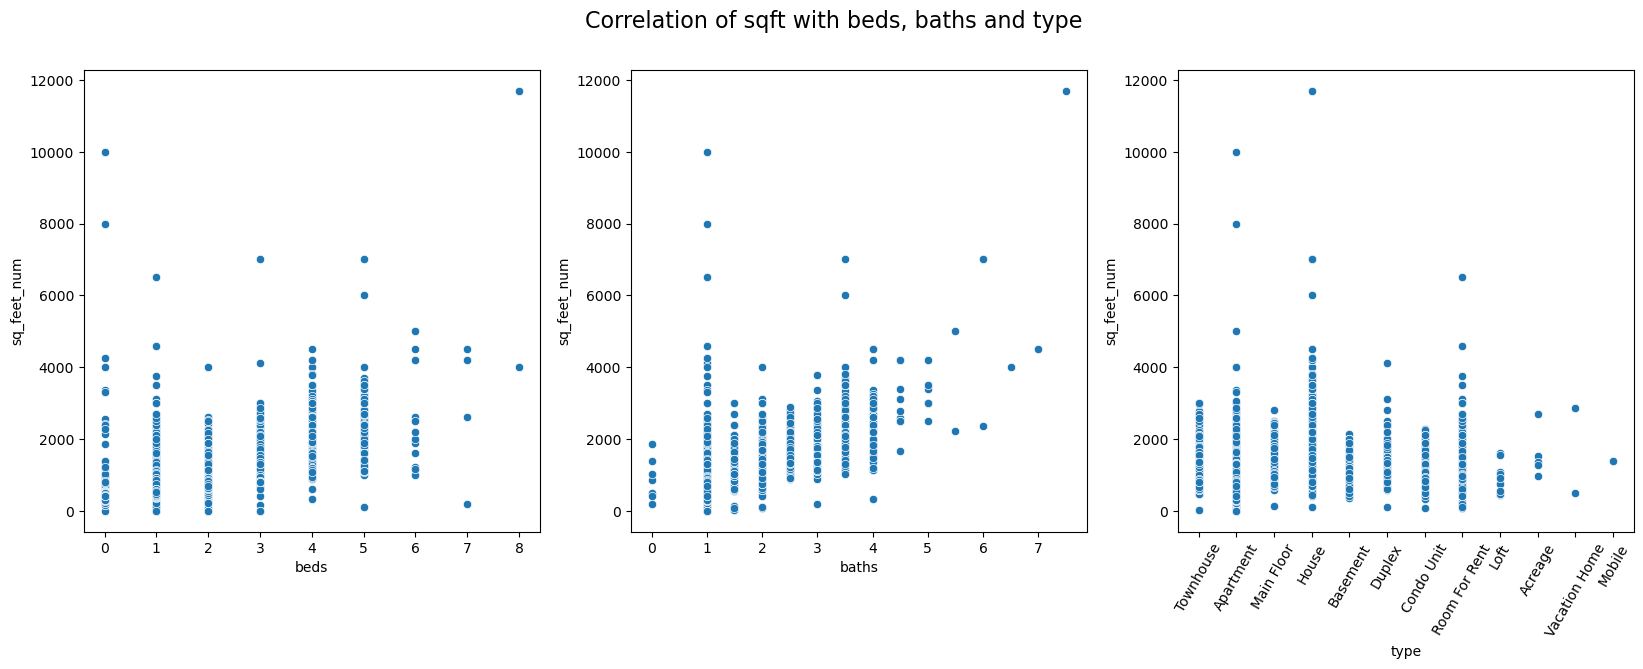

In [993]:
# Visualization
figa, (axa, axb, axc)=plt.subplots(ncols=3, figsize=(20,6))
sns.scatterplot(ax=axa, x=rent_v1['beds'], y=rent_v1['sq_feet_num'])
sns.scatterplot(ax=axb, x=rent_v1['baths'], y=rent_v1['sq_feet_num'])
sns.scatterplot(ax=axc, x=rent_v1['type'], y=rent_v1['sq_feet_num'])

axc.tick_params(axis='x',rotation=60)
figa.suptitle('Correlation of sqft with beds, baths and type', fontsize=16);

In [994]:
# Define the imputer
imputer_n = SimpleImputer(strategy='mean')

# Function to apply imputation based on categories
def impute_group_mean(df):
    # Reshape data to use SimpleImputer
    reshaped_values = df['sq_feet_num'].values.reshape(-1, 1)
    # Fit and transform the data
    df['sq_feet_num'] = imputer_n.fit_transform(reshaped_values)
    return df

The above visualization showed that `baths` is the best indicator to sq_feet.

In [995]:
rent_v1.groupby(['baths'])['sq_feet_num'].mean()
# Good stand, no missing value

baths
0.0      887.857143
1.0      722.820059
1.5     1103.708360
2.0     1010.286130
2.5     1590.190159
3.0     1789.720430
3.5     2278.491892
4.0     2406.093023
4.5     2989.444444
5.0     3264.666667
5.5     3615.000000
6.0     4675.000000
6.5     4000.000000
7.0     4500.000000
7.5    11700.000000
Name: sq_feet_num, dtype: float64

In [996]:
# Imputated based on different baths
# Note that this variable is called rent_imputed_beds because baths is a feature used at the last minute
rent_imputed_beds= rent_v1.groupby(['baths']).apply(impute_group_mean)
rent_imputed_beds.sample(5)

,city,province,latitude,longitude,type,price,beds,baths,sq_feet,smoking,cats,dogs,lease_term_1,furnishing_1,sq_feet_num
2511,Calgary,Alberta,51.042501,-114.121147,Townhouse,3300.0,2,2.5,NaN,Non-Smoking,False,False,Long Term,Unfurnished,1590.190159
16134,Côte Saint-Luc,Quebec,45.490019,-73.651972,Apartment,2535.0,1,1.5,850,Non-Smoking,False,False,Long Term,Unfurnished,850.000000
13634,Toronto,Ontario,43.651404,-79.357130,Apartment,3627.0,2,2.0,794,Non-Smoking,True,True,Long Term,Unfurnished,794.000000
8458,New Westminster,British Columbia,49.208522,-122.925965,Apartment,2195.0,1,1.0,525,Non-Smoking,True,True,Long Term,Unfurnished,525.000000
4172,Calgary,Alberta,51.164525,-113.964405,Apartment,2200.0,2,2.0,950,Non-Smoking,True,True,Negotiable,Unfurnished,950.000000


In [997]:
# There is formatting issue in sq_feet
# Eyeball check to see if the imputation makes sense
import re

def num(s):
    if not isinstance(s, str):
        return False
    if s.strip() == "":
        return False
    
    pattern = re.compile(r'[a-zA-Z!@#$%^&*()_+{}\[\]:;"\'<>,/?|\\`~]')
    return bool(pattern.match(s))

In [998]:
# rows with wrongly formatted sq_feet
f_issue=rent_imputed_beds[rent_imputed_beds['sq_feet'].apply(num)][['beds','baths','type','sq_feet','sq_feet_num']]
f_issue.head()

,beds,baths,type,sq_feet,sq_feet_num
142,3,2.5,Townhouse,approx. 1400,1590.190159
772,2,1.0,Basement,~1000,722.820059
885,1,1.0,Townhouse,Large,722.820059
960,2,1.0,Main Floor,Approximately 700sf,722.820059
983,3,2.5,House,approx 2200,1590.190159


Quick eyeballing showed that it is a good estimation. 

In [999]:
rent_v3=rent_v3.join(rent_imputed_beds['sq_feet_num'])

In [1000]:
rent_v3.drop(columns='sq_feet',inplace=True)

### Overview

`rent_v3` is the cleaned dataset that will be used in the `model1` creation.

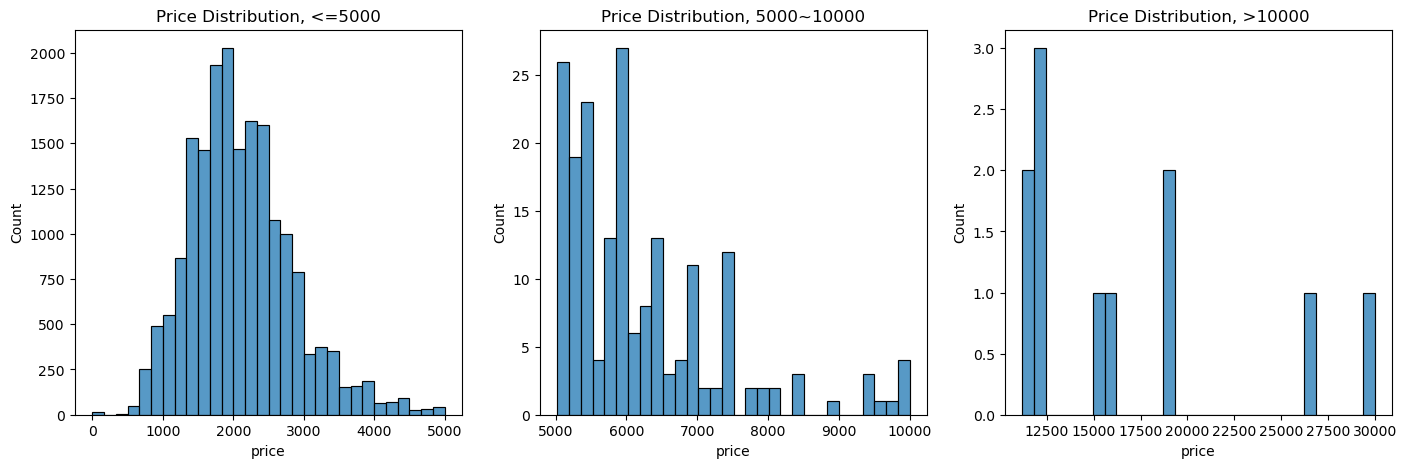

In [1001]:
# Visulization of price
# Distribution in price
fig4, (ax4,ax5, ax6) = plt.subplots(ncols=3, figsize=(17,5))

sns.histplot(ax=ax4, data=rent_v3[rent_v3['price']<=5000], x='price', bins=30)
ax4.set_title("Price Distribution, <=5000")

sns.histplot(ax=ax5, data=rent_v3[(rent_v3['price']>5000)&(rent_v3['price']<=10000)], x='price', bins=30)
ax5.set_title("Price Distribution, 5000~10000")

sns.histplot(ax=ax6, data=rent_v3[rent_v3['price']>10000], x='price', bins=30)
ax6.set_title("Price Distribution, >10000");

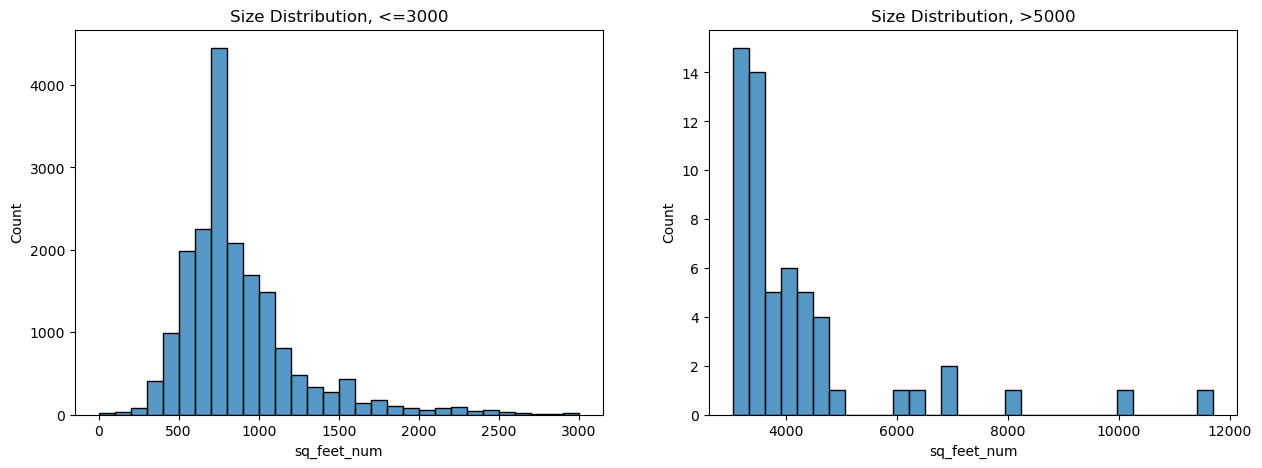

In [1002]:
# Visualization of sq_feet
fig7, (ax7,ax8) = plt.subplots(ncols=2, figsize=(15,5))

sns.histplot(ax=ax7, data=rent_v3[rent_v3['sq_feet_num']<=3000], x='sq_feet_num', bins=30)
ax7.set_title("Size Distribution, <=3000")

sns.histplot(ax=ax8, data=rent_v3[rent_v3['sq_feet_num']>3000], x='sq_feet_num', bins=30)
ax8.set_title("Size Distribution, >5000");

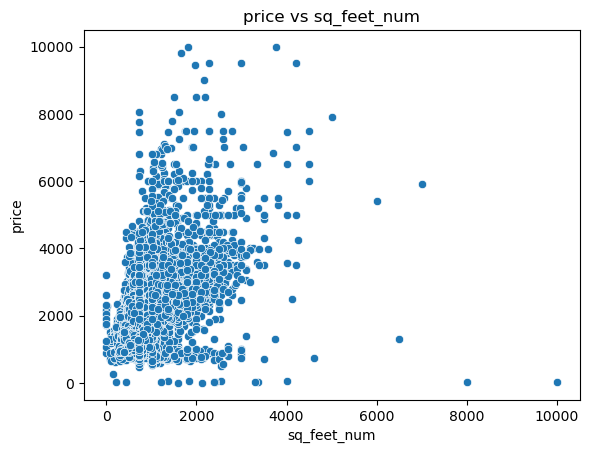

In [1003]:
# Visualzation
figb, axb = plt.subplots()

sns.scatterplot(ax=axb, x=rent_v3[rent_v3['price']<10000]['sq_feet_num'], y=rent_v3[rent_v3['price']<10000]['price'])

axb.set_title('price vs sq_feet_num');

Insights:
1. Outliers in `price` and `sq_feet_num` are noticed, but they will be handled and tested later.
2. It is clear in the `figb` that:

    a. `price` positively related with `sq_feet_num`, and the trend is linear.
    
    b. There are some other features that can determine the look of the formula.

---
## Model1 Creation

All features will be used in `rent_v3` except for `longitude`, `latitude` and `province` as city encode approximately the same info.

In [1004]:
def modeling(model, X, y, test_time):
     MAE = []
     MSE = []
     RMSE = []
     R2 = []
     trail = []
     for i in range(1,test_time+1):
        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

        # Scaling
        scaler = RobustScaler()
        X_train['sq_feet_num'] = scaler.fit_transform(pd.DataFrame(X_train['sq_feet_num']))
        X_test['sq_feet_num'] = scaler.transform(pd.DataFrame(X_test['sq_feet_num']))

        # Train
        model.fit(X_train, y_train)

        # Test
        y_pred = model.predict(X_test)

        # Evaluation
        MAE.append(mean_absolute_error(y_test, y_pred))
        MSE.append(mean_squared_error(y_test, y_pred))
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        R2.append(model.score(X_test,y_test))
        trail.append(i)

     # Evaluation df
     eval_df = pd.DataFrame({'trail':trail,'MAE':MAE,'MSE':MSE,'RMSE':RMSE,'R2':R2})

     return eval_df

### Model 1a - Lasso

In [1005]:
# Separate features from target
X_1 = rent_v3.drop(columns=['longitude','province','price','latitude'])
y_1 = rent_v3['price']

# Model initiation
model1a = LassoCV(eps=0.01, n_alphas=100)

# test
model1a_metrics = modeling(model1a, X_1, y_1, 10)
model1a_metrics.mean()

trail         5.500000
MAE         380.155396
MSE      425146.212774
RMSE        647.462820
R2            0.506335
dtype: float64

### Model 1b - Ridge

In [1006]:
# Model initialization
cv = KFold(n_splits=5)
model1b = RidgeCV((0.1, 1.0, 10.0), scoring='neg_mean_absolute_error', cv=5) 

# Model evaluation
model1b_metrics = modeling(model1b, X_1, y_1, 10)
model1b_metrics.mean()

trail         5.500000
MAE         310.940242
MSE      364228.544660
RMSE        597.155325
R2            0.599308
dtype: float64

`Ridge` outperformed `Lasso` based on the average R2 score. 

---
## Model1 Modified - outlier handling

#### type 

In [1007]:
#Drop type == loft, acreage, vacation home, mobile
# Recall data
rent_imputed_beds['type'].value_counts()

Apartment        13200
Condo Unit        1306
Townhouse         1050
House             1027
Basement          1017
Main Floor         468
Room For Rent      410
Duplex             310
Loft                15
Acreage              8
Vacation Home        2
Mobile               2
Name: type, dtype: int64

In [1008]:
# Drop
rent_v4 = rent_imputed_beds.drop(rent_imputed_beds[rent_imputed_beds['type'].isin(['Loft','Acreage','Vacation Home','Mobile'])].index).reset_index(drop=True)

# Check
rent_v4['type'].value_counts() # Pass


Apartment        13200
Condo Unit        1306
Townhouse         1050
House             1027
Basement          1017
Main Floor         468
Room For Rent      410
Duplex             310
Name: type, dtype: int64

#### sq_feet_num
To perform a log transformation so that the impact of the outliers may be reduced.

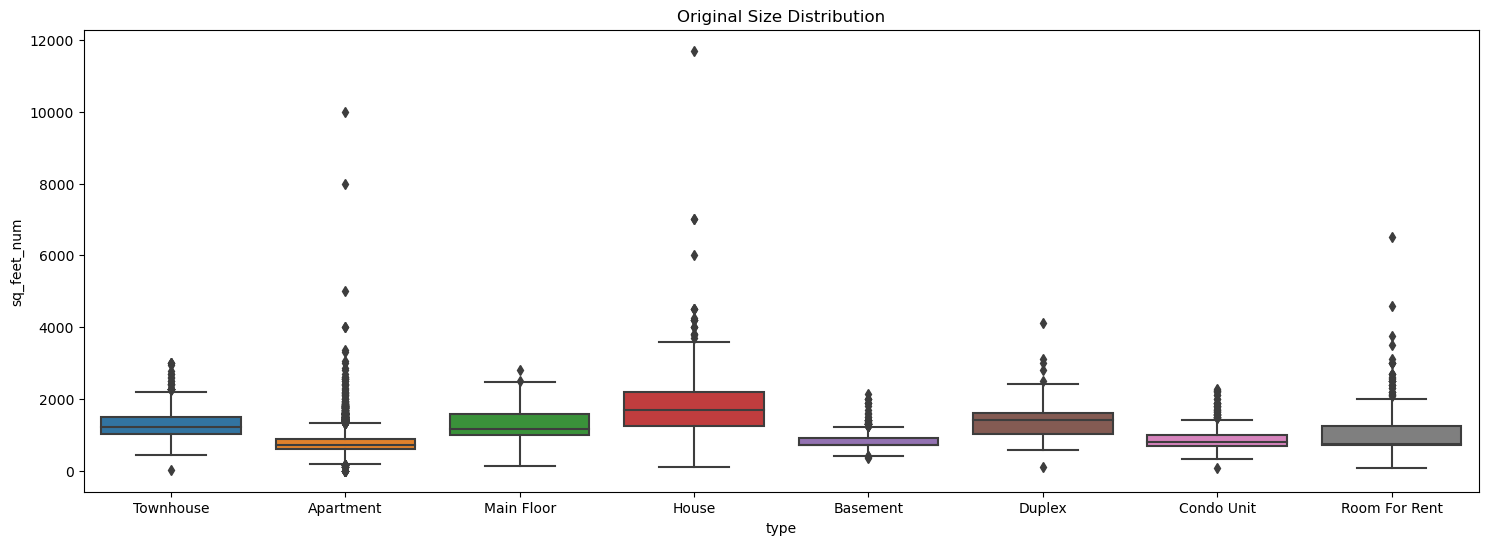

In [1009]:
# Visualization
fig10, ax10 = plt.subplots(figsize=(18,6))

sns.boxplot(ax=ax10, x=rent_v4['type'], y=rent_v4['sq_feet_num'])

ax10.set_title('Original Size Distribution');

Note that there are very small values, which might be invalid. Here, a size below 100 sq feet is considered an invalid entry for sq_feet_num, as 100 sq feet is smaller than a typical parking space, which is essentially a cell. Since the regression model is sensitive to outliers, these points need further imputation.

In [1010]:
# Potental Invalid data
rent_v4[rent_v4['sq_feet_num']<=100].shape

(22, 15)

In [1011]:
# Imputation
rent_v4.loc[(rent_v4['sq_feet_num']<=100), 'sq_feet_num']=None
rent_v4=rent_v4.groupby(['baths']).apply(impute_group_mean)

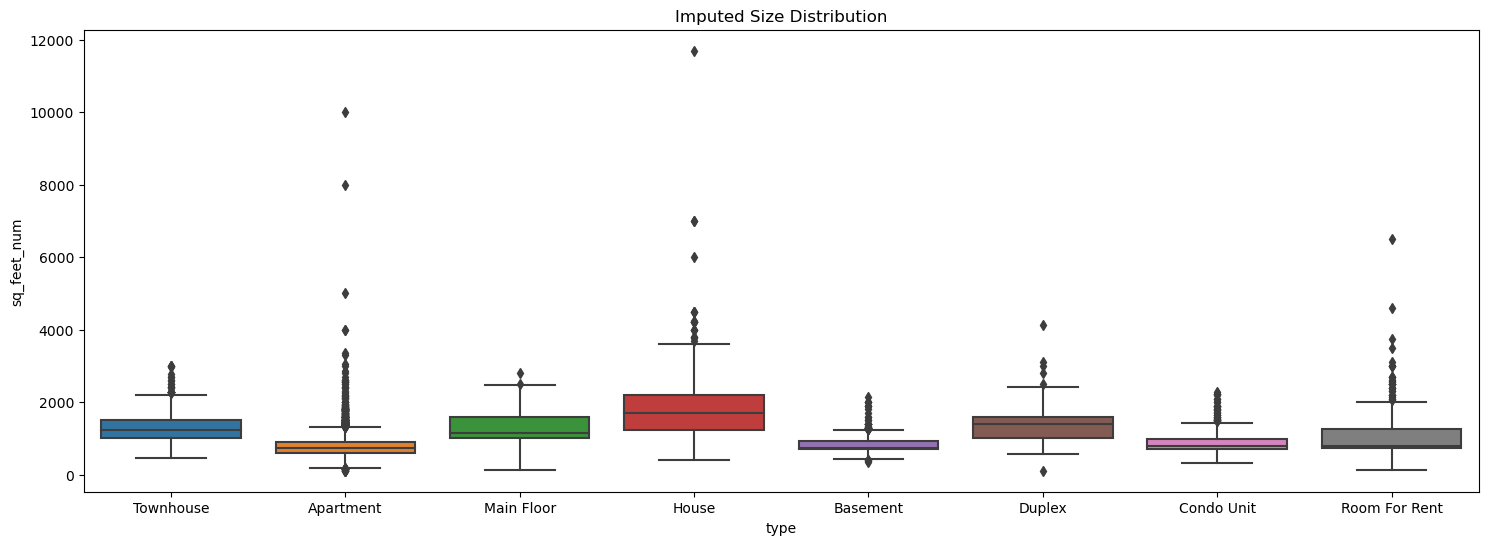

In [1012]:
# Visualzaition after imputing 'invalid' values
fig12, ax12 = plt.subplots(figsize=(18,6))
sns.boxplot(ax=ax12, x=rent_v4['type'], y=rent_v4['sq_feet_num'])
ax12.set_title('Imputed Size Distribution');

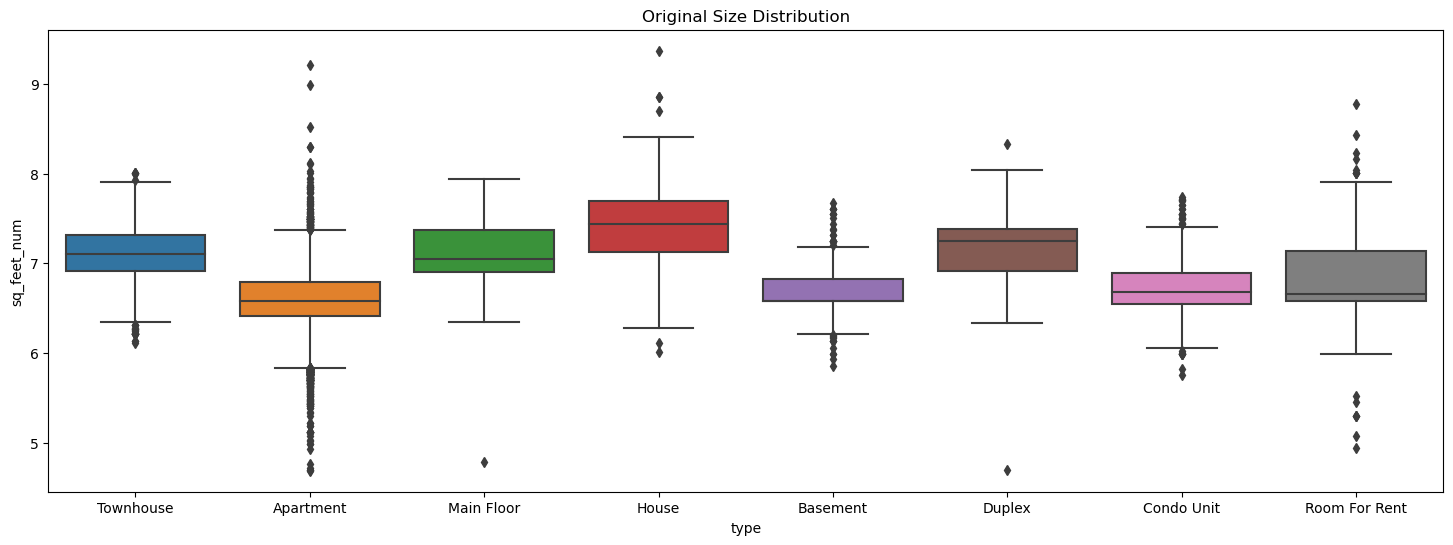

In [1013]:
# Visualzaition after log transformation
fig11, ax11 = plt.subplots(figsize=(18,6))
sns.boxplot(ax=ax11, x=rent_v4['type'], y=np.log(rent_v4['sq_feet_num']))
ax11.set_title('Original Size Distribution');

In [1014]:
# log transformation
rent_v4['sq_feet_num']=np.log(rent_v4['sq_feet_num'])

In [1015]:
# Encoding
rent_v4.drop(columns='sq_feet',inplace=True)
rent_v5 = encoding(rent_v4)

# Feature separated from target
X_1_m = rent_v5.drop(columns=['longitude','province','price','latitude'])
y_1_m = rent_v5['price']

In [1016]:
# Test lasso
model1a_metrics_m = modeling(model1a, X_1_m, y_1_m, 10)
model1a_metrics_m.mean()

trail         5.500000
MAE         371.642493
MSE      377219.491547
RMSE        611.572046
R2            0.543146
dtype: float64

In [1017]:
# Test Ridge
model1b_metrics_m = modeling(model1b, X_1_m, y_1_m, 10)
model1b_metrics_m.mean()

trail         5.500000
MAE         309.227168
MSE      334367.367357
RMSE        570.177345
R2            0.610410
dtype: float64

`Ridge` still outperformed `Lasso` based on R2 score. In this case, removing outliers and log transforming `sq_feet_num` seems to negatively impact the performance, but the log transformed version will be used in the following models. 

---
## Model 2 - Interaction

### beds and baths per sqft

In [1018]:
rent_v4['bedroom/sqft'] = rent_v4['beds']/np.exp(rent_v4['sq_feet_num'])
rent_v4['bathroom/sqft'] = rent_v4['baths']/np.exp(rent_v4['sq_feet_num'])

### price/sqft outlier

In [1019]:
# Convert logged value to original
rent_v4['price/sqft'] = rent_v4['price']/np.exp(rent_v4['sq_feet_num'])

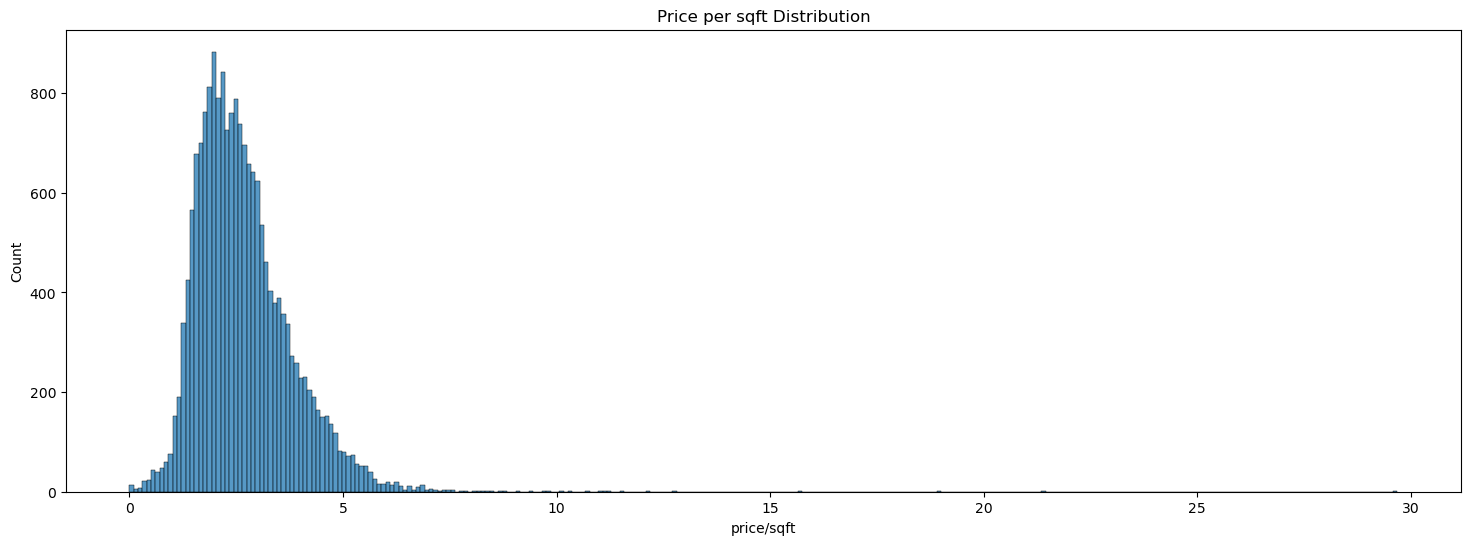

In [1020]:
# Visualization
fig15, ax15 = plt.subplots(figsize=(18,6))


sns.histplot(ax=ax15, x=rent_v4['price/sqft'])

ax15.set_title('Price per sqft Distribution');

Looks like a bell curve but with significant outliers

In [1021]:
# Look for outliers
unit_pr = rent_v4['price/sqft']
mean_unit_pr = np.mean(unit_pr)
sigma_unit_pr=np.std(unit_pr)

cut = mean_unit_pr + 3*sigma_unit_pr
cut_2 = mean_unit_pr - 3*sigma_unit_pr

# Check
rent_v4[(rent_v4['price/sqft']>=cut)|(rent_v4['price/sqft']<cut_2)].shape # Consider to drop

(144, 17)

In [1022]:
rent_v6 = rent_v4.drop(rent_v4[rent_v4['price/sqft']>cut].index)
rent_v6.reset_index(inplace=True, drop=True)

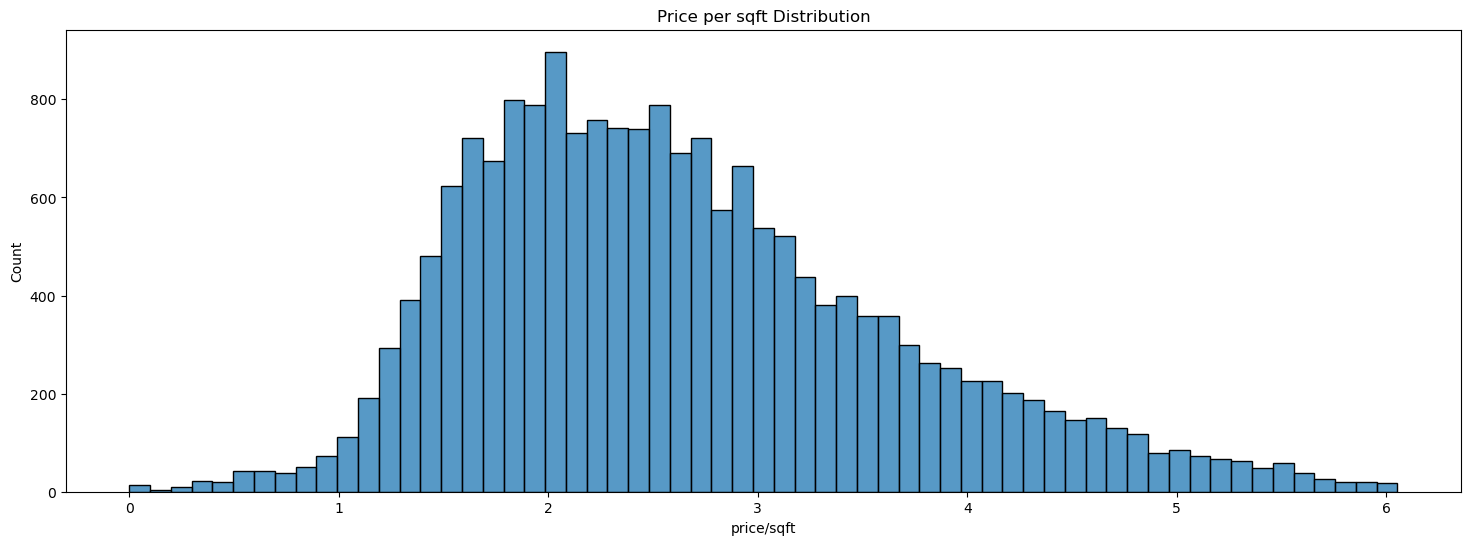

In [1023]:
# Visualization
fig16, ax16 = plt.subplots(figsize=(18,6))


sns.histplot(ax=ax16, x=rent_v6['price/sqft'])

ax16.set_title('Price per sqft Distribution');

In [1024]:
# Encoding
rent_v7 = encoding(rent_v6)

In [1025]:
# Modification
def modeling2(model, X, y, test_time):
     MAE = []
     MSE = []
     RMSE = []
     R2 = []
     trail = []
     for i in range(1,test_time+1):
        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

        # Scaling
        scaler = RobustScaler()
        X_train[['sq_feet_num','bedroom/sqft','bathroom/sqft']] = scaler.fit_transform(pd.DataFrame(X_train[['sq_feet_num','bedroom/sqft','bathroom/sqft']]))
        X_test[['sq_feet_num','bedroom/sqft','bathroom/sqft']] = scaler.transform(pd.DataFrame(X_test[['sq_feet_num','bedroom/sqft','bathroom/sqft']]))

        # Train
        model.fit(X_train, y_train)

        # Test
        y_pred = model.predict(X_test)

        # Evaluation
        MAE.append(mean_absolute_error(y_test, y_pred))
        MSE.append(mean_squared_error(y_test, y_pred))
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        R2.append(model.score(X_test,y_test))
        trail.append(i)

     # Evaluation df
     eval_df = pd.DataFrame({'trail':trail,'MAE':MAE,'MSE':MSE,'RMSE':RMSE,'R2':R2})
   
     return eval_df

In [1026]:
# Feature separated from target
X_2= rent_v7.drop(columns=['longitude','province','price','latitude','price/sqft'])
y_2 = rent_v7['price']

In [1027]:
# Test lasso
model2_metrics = modeling2(model1a, X_2, y_2, 10)
model2_metrics.mean()

trail         5.500000
MAE         352.722662
MSE      300222.613938
RMSE        545.924254
R2            0.575928
dtype: float64

In [1028]:
# Test Ridge
model2_metrics = modeling2(model1b, X_2, y_2, 10)
model2_metrics.mean()

trail         5.500000
MAE         297.453191
MSE      236929.670931
RMSE        483.671752
R2            0.670605
dtype: float64

`Ridge` still outperformed `Lasso` based on R2 score. Creating interaction terms and removing outliers from `price/sqft` seems to postively impact the model performance. 

## Model 3 - Creation of Zipcode Feature
Normally zipcode is an important feature to predict rental price. Although this information is not given in the dataset, by using `geopy`, the zipcode can be found with given corordinate. The code `get_zipcode()` is used ([Check detail](https://gis.stackexchange.com/questions/352961/converting-lat-lon-to-postal-code-using-python)).

The cooridnates are rounded to 2 decimal places as:
1. `get_zipcode()` is not a fast function. There are 8000+ distinct cooridinates, to be able to get the full datat, approximately 5.5hrs are needed. 
2. A 0.01 difference in cooridnate will result in a 1 km difference in distance. For the purpose of this project, the error is well tolerated. 

In [1029]:
import geopy

In [1030]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))

    # If there is no matching zipcode for a given coordinate, an error will be raised
    try:
        return location.raw['address']['postcode']
    
    # If no zipcode matched, return None
    except:
        return None

In [1031]:
# Round longitude and latitude and find unique values
lon_lat=rent_v1[['longitude','latitude']].round(2).drop_duplicates()
lon_lat

,longitude,latitude
0,-114.01,51.31
5,-114.02,51.27
9,-114.01,51.29
10,-114.02,51.30
11,-114.00,51.28
...,...,...
18774,-102.48,51.20
18779,-102.47,51.20
18781,-102.44,51.21
18787,-102.46,51.22


**Warning: Please do not run the codes below!! It will take 25mins**

In [1032]:
# # Find Zipcode based on coordinate

# geo_locator = geopy.Nominatim(user_agent='1234')

# zipcodes = lon_lat.apply(get_zipcode, axis=1, geolocator=geo_locator, lat_field='latitude', lon_field='longitude')

# # Export
# zipcodes.to_csv('zipcodes.csv',index=False)

In [1033]:
# import zipcodes
postcode = pd.read_csv('zipcodes.csv')
postcode.drop(columns='i',inplace=True)
postcode.columns = ['postcode']
postcode.head(5)

,postcode
0,T4B 0J6
1,T4B 2X2
2,T4B 0P9
3,T4B 0L5
4,T4A 1L9


In [1034]:
# Join coordiante and matching zipcode
lon_lat.reset_index(drop=True,inplace=True)
code_ll = lon_lat.join(postcode)
code_ll[code_ll['postcode'].isna()].drop_duplicates().shape #pass

(31, 3)

Note that there are missing values in the joined dataset `code_ll`

In [1035]:
# Fill in the missing postcode by the postcode of its closest point

def find_closest(df,point):

    tree=KDTree(df[['longitude','latitude']])
    distance,index = tree.query(point)
    closest_point_code = df.iloc[index]['postcode']

    return closest_point_code

In [1036]:
# Loop to fill in NA
points_df = code_ll[code_ll['postcode'].isna()][['longitude','latitude']]
postcode_imputed = []
for i in range(points_df.shape[0]):
    postcode_imputed.append(find_closest(code_ll.dropna(),points_df.iloc[i]))
    
points_df['postcode'] = postcode_imputed
full_code = pd.concat([code_ll.dropna(), points_df])

In [1037]:
# Merge
rent_v6['longitude'], rent_v6['latitude'] = rent_v6['longitude'].round(2), rent_v6['latitude'].round(2)
rent_v8 = pd.merge(rent_v6, full_code, how='left',on=['longitude','latitude'])

# Check
rent_v8['postcode'].isna().sum()

0

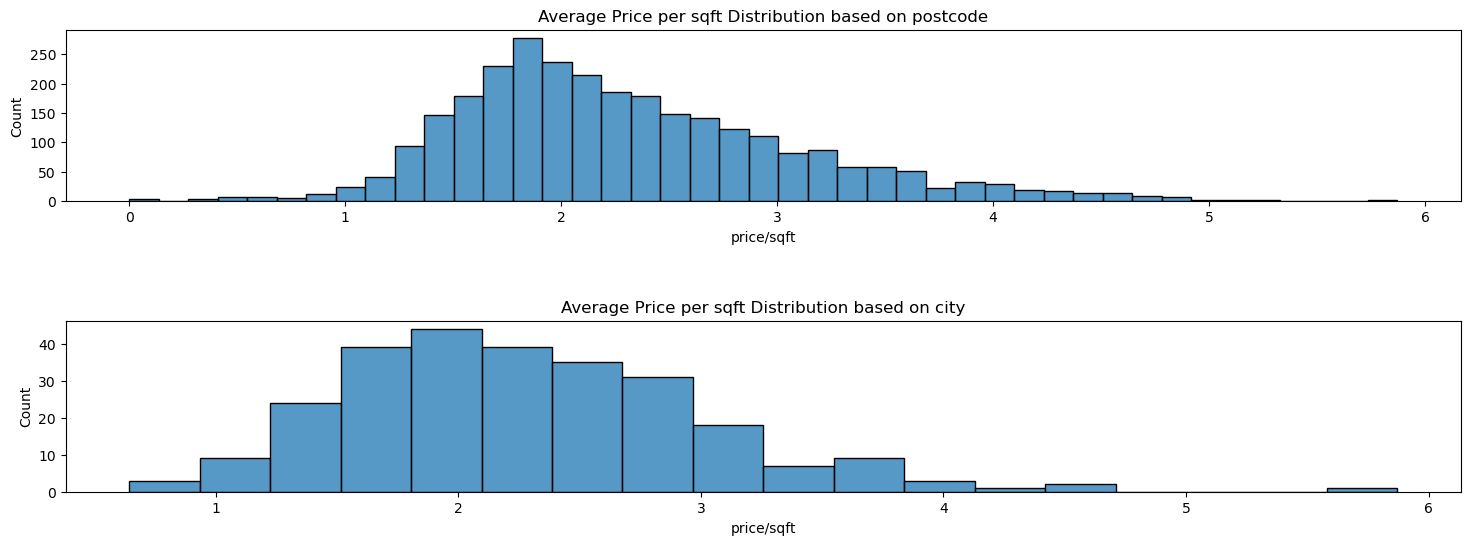

In [1038]:
# Visualization
est = rent_v8.groupby('postcode')['price/sqft'].mean().reset_index()
est2 = rent_v8.groupby('city')['price/sqft'].mean().reset_index()

fig17, (ax17,ax18) = plt.subplots(figsize=(18,6),nrows=2)
fig17.subplots_adjust(hspace=0.7)

sns.histplot(ax=ax17, x=est['price/sqft'])
ax17.set_title('Average Price per sqft Distribution based on postcode')

sns.histplot(ax=ax18, x=est2['price/sqft'])
ax18.set_title('Average Price per sqft Distribution based on city');

`fig17` showed that postcode encode more detailed information in terms of predicting the average price per sqft. However, since there are almost 3000 distinct postcode, it is not good to use it as a categorical data. Therefore, zipcodes need to be grouped based on the average price per sqft, which is a direct indicator of `price`.

In [1039]:
# Grouping
est =est.groupby('postcode')['price/sqft'].mean().reset_index()
est.loc[(est['price/sqft']<=1), 'postcode_index']=0
est.loc[(est['price/sqft']>1)&(est['price/sqft']<=2), 'postcode_index']=2
est.loc[(est['price/sqft']>2)&(est['price/sqft']<=3), 'postcode_index']=3
est.loc[(est['price/sqft']>3)&(est['price/sqft']<=4), 'postcode_index']=4
est.loc[(est['price/sqft']>4), 'postcode_index']=5

est.drop(columns='price/sqft', inplace=True)

In [1040]:
rent_v8 = pd.merge(rent_v8, est, how='left',on=['postcode'])
rent_v8

,city,province,latitude,longitude,type,price,beds,baths,smoking,cats,dogs,lease_term_1,furnishing_1,sq_feet_num,bedroom/sqft,bathroom/sqft,price/sqft,postcode,postcode_index
0,Airdrie,Alberta,51.31,-114.01,Townhouse,2495.0,2,2.5,Non-Smoking,True,True,Long Term,Unfurnished,7.246368,0.001426,0.001782,1.778332,T4B 0J6,2.0
1,Airdrie,Alberta,51.31,-114.01,Townhouse,2695.0,3,2.5,Non-Smoking,True,True,Long Term,Unfurnished,7.310550,0.002005,0.001671,1.801471,T4B 0J6,2.0
2,Airdrie,Alberta,51.31,-114.01,Townhouse,2295.0,2,2.5,Non-Smoking,True,True,Long Term,Unfurnished,7.073270,0.001695,0.002119,1.944915,T4B 0J6,2.0
3,Airdrie,Alberta,51.31,-114.01,Townhouse,2095.0,2,2.5,Non-Smoking,True,True,Long Term,Unfurnished,7.246368,0.001426,0.001782,1.493229,T4B 0J6,2.0
4,Airdrie,Alberta,51.31,-114.01,Townhouse,2495.0,2,2.5,Non-Smoking,True,True,Long Term,Unfurnished,7.208600,0.001480,0.001850,1.846780,T4B 0J6,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,Yorkton,Saskatchewan,51.20,-102.48,Apartment,920.0,0,1.0,Non-Smoking,True,True,Long Term,Unfurnished,5.991465,0.000000,0.002500,2.300000,S3N 2T2,3.0
18640,Yorkton,Saskatchewan,51.20,-102.48,Apartment,1450.0,3,1.0,Non-Smoking,True,True,Long Term,Unfurnished,6.697034,0.003704,0.001235,1.790123,S3N 2T2,3.0
18641,Yorkton,Saskatchewan,51.20,-102.49,Apartment,1125.0,1,1.0,Non-Smoking,True,True,Long Term,Unfurnished,6.253829,0.001923,0.001923,2.163462,S3N 0P3,2.0
18642,Yorkton,Saskatchewan,51.20,-102.49,Apartment,920.0,0,1.0,Non-Smoking,True,True,Long Term,Unfurnished,5.991465,0.000000,0.002500,2.300000,S3N 0P3,2.0


In [1041]:
def encoding_v3(v1):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(v1[['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']])
    v2 = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']))
    v3 = v1.drop(columns=['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']).join(v2)
    return v3

In [1042]:
rent_v9 = encoding_v3(rent_v8)
rent_v9

,city,province,latitude,longitude,price,sq_feet_num,bedroom/sqft,bathroom/sqft,price/sqft,postcode,...,type_House,type_Main Floor,type_Room For Rent,type_Townhouse,cats_True,dogs_True,postcode_index_2.0,postcode_index_3.0,postcode_index_4.0,postcode_index_5.0
0,Airdrie,Alberta,51.31,-114.01,2495.0,7.246368,0.001426,0.001782,1.778332,T4B 0J6,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,Airdrie,Alberta,51.31,-114.01,2695.0,7.310550,0.002005,0.001671,1.801471,T4B 0J6,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Airdrie,Alberta,51.31,-114.01,2295.0,7.073270,0.001695,0.002119,1.944915,T4B 0J6,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,Airdrie,Alberta,51.31,-114.01,2095.0,7.246368,0.001426,0.001782,1.493229,T4B 0J6,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,Airdrie,Alberta,51.31,-114.01,2495.0,7.208600,0.001480,0.001850,1.846780,T4B 0J6,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,Yorkton,Saskatchewan,51.20,-102.48,920.0,5.991465,0.000000,0.002500,2.300000,S3N 2T2,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
18640,Yorkton,Saskatchewan,51.20,-102.48,1450.0,6.697034,0.003704,0.001235,1.790123,S3N 2T2,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
18641,Yorkton,Saskatchewan,51.20,-102.49,1125.0,6.253829,0.001923,0.001923,2.163462,S3N 0P3,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
18642,Yorkton,Saskatchewan,51.20,-102.49,920.0,5.991465,0.000000,0.002500,2.300000,S3N 0P3,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [1043]:
# Feature separated from target
X_3= rent_v9.drop(columns=['longitude','province','price','latitude','price/sqft','city','postcode'])
y_3 = rent_v9['price']

In [1044]:
# Test Ridge
model3_metrics = modeling2(model1b, X_3, y_3, 10)
model3_metrics.mean()

trail         5.500000
MAE         315.059161
MSE      234171.995436
RMSE        481.774988
R2            0.678493
dtype: float64

In [1045]:
# Test Lasso
model3_metrics = modeling2(model1a, X_3, y_3, 10)
model3_metrics.mean()

trail         5.500000
MAE         320.314907
MSE      280576.318948
RMSE        525.335490
R2            0.642604
dtype: float64

`Ridge` still outperformed `Lasso` based on R2 score.

Note that there is an overfitting issue in this final model3, so the metrics would not hold. Since `postcode_index` is assigned based on the average of `price/sqft` per postcode of the full dataset, but not the training subset, the model has actually seen the testing data. This issue can be fixed by separating out the training and testing prior to the assignment of `postcode_index`. However, due to time restrain, yes time is limited omg, this is not shown. 

This issue can be reflected by the huge improvement in the performance of `Lasso` model. Since `price/sqft` is directly linked with `price`, `Lasso` can use potentially just the `postcode_index` to predict the `price`. 

There is another overfitting issue linked with the final model. Since `postcode` and `postcode_idnex` are created as extra feature based on the geographic location of the property, if the loction of the testing property cannot match to a close point in `rent_v8`, the assignment of `post_code_index` will be off. Here is an extreme example: if the property is located in New York, the closest `postcode` matched will potentially be somewhere in Montreal, but the rental price is definitely not the same. This can be fixed by using a bigger training dataset that contains more complete information, or by applying strict data validation prior to predict the price.

## Final model

In [1046]:
# Compare column name
def compare(df1, df2): # To do sanity check of column names
    if len(list(df1.columns)) >= len(list(df2.columns)):
        a = list(df1.columns)
        b = list(df2.columns)
    
    else:
        a = list(df2.columns)
        b = list(df1.columns)


    diff = []
    for names in a:
        if names not in b:
            diff.append(names)
    return diff

In [1047]:
# Feature/Target separation
X_f= rent_v8.drop(columns=['longitude','province','price','latitude','price/sqft','city','postcode'])
y_f = rent_v8['price']

# Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(X_f[['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']])
encoded_col = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']))
df_train = X_f.drop(columns=['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']).join(encoded_col)

# Sanity test
compare(df_train, X_3) # Pass

# Scaling
scaler = RobustScaler()
df_train[['sq_feet_num','bedroom/sqft','bathroom/sqft']] = scaler.fit_transform(pd.DataFrame(df_train[['sq_feet_num','bedroom/sqft','bathroom/sqft']]))


# model initiation
cv_f = KFold(n_splits=5)
model_f = RidgeCV((0.1, 1.0, 10.0), scoring='neg_mean_absolute_error', cv=5) 

# Training
model_f.fit(df_train, y_f)

RidgeCV(cv=5, scoring='neg_mean_absolute_error')

In [1048]:
# Formula parameters
coef = model_f.coef_.reshape((-1,1))

pd.DataFrame(coef, index = df_train.columns, columns=['coef']).T

,sq_feet_num,bedroom/sqft,bathroom/sqft,lease_term_1_Negotiable,lease_term_1_Short Term,furnishing_1_Negotiable,furnishing_1_Unfurnished,beds_1,beds_2,beds_3,...,type_House,type_Main Floor,type_Room For Rent,type_Townhouse,cats_True,dogs_True,postcode_index_2.0,postcode_index_3.0,postcode_index_4.0,postcode_index_5.0
coef,431.545591,-76.786326,77.7585,100.036599,291.473932,-154.295289,-270.331894,366.917582,629.075176,925.884307,...,33.117975,-199.484937,-1067.602932,-163.23654,-37.047305,100.478504,589.922029,1081.207093,1682.800749,2310.504539


## Testing
Data will be used from [rentfaster](https://www.rentfaster.ca/bc/victoria/rentals/?l=12,48.4706,-123.2231), to test the actual performance of the model. 

In [1049]:
# test_df estblishment
test_df = pd.DataFrame({'index' : [1,2,3],
                        'city' : ['Langford', 'Montréal', 'Toronto'], # Not used
                        'province' : ['BC', 'QC', 'ON'], # Not used, therefore the code is used for simplicity
                        'address' : ['2763 Spencer Rd.', '5460 Sunnybrooke Avenue', '5 Short Crescent'],
                        'latitude' : [48.45, 45.46, 43.91],
                        'longitude' : [-123.51, -73.66, -78.78],
                        'lease_term_1': ['Long Term', 'Long Term', 'Long Term'],
                        'type' : ['Apartment', 'Apartment', 'House'],
                        'price':[1900, 1325, 2995],
                        'beds' : [2, 1, 3],
                        'baths' : [2, 1, 3],
                        'sq_feet_num' : [889, 750, 1500],
                        'link' : ['https://www.rentfaster.ca/bc/langford/rentals/apartment/2-bedrooms/pet-friendly/577860?-RSYNC',
                                    'https://www.rentfaster.ca/qc/c-te-saint-luc/rentals/apartment/1-bedroom/pet-friendly/477766?-RSYNC',
                                    'https://www.rentfaster.ca/on/clarington/rentals/house/3-bedrooms/pet-friendly/578012?-RSYNC'],
                        'furnishing_1' : ['Unfurnished', 'Unfurnished', 'Unfurnished'],
                        'availability_date' : [None, None, None], # Not used
                        'smoking' : ['Non-Smoking', 'Non-Smoking', 'Non-Smoking'],
                        'cats' : [True, True, True],
                        'dogs' : [False, True, True]})
rent_org.shape[1] == test_df.shape[1] # Pass


True

In [1050]:
# Feature craetion to match format of rent_v6
test_df['bedroom/sqft'] = test_df['beds']/test_df['sq_feet_num']
test_df['bathroom/sqft'] = test_df['baths']/test_df['sq_feet_num']
test_df['price/sqft'] = [None, None, None] # We are pretending that we do not know the pricert
test_df['sq_feet_num'] = np.log(test_df['sq_feet_num'])

to_drop = []
for names in list(test_df.columns):
    if names not in list(rent_v6.columns):
        to_drop.append(names)

test_df.drop(columns=to_drop,inplace=True)

test_df.isna().sum()

city             0
province         0
latitude         0
longitude        0
lease_term_1     0
type             0
price            0
beds             0
baths            0
sq_feet_num      0
furnishing_1     0
smoking          0
cats             0
dogs             0
bedroom/sqft     0
bathroom/sqft    0
price/sqft       3
dtype: int64

Up to this point, the `test_df` should match teh format of `rent_v6`.

In [1051]:
# Match postal code
test_points_df = test_df[['longitude','latitude']]
test_postcode_imputed = []
for i in range(test_points_df.shape[0]):
    test_postcode_imputed.append(find_closest(rent_v8,test_points_df.iloc[i]))
    
test_df['postcode'] = test_postcode_imputed
test_df = pd.merge(test_df, est, how='left', on='postcode')

# Sanity test
set(test_df.columns) == set(rent_v8.columns) # Pass

True

Up to this point, the `test_df` should match teh format of `rent_v8`.

In [1052]:
# The following is better to be converted into a formula so that it can be applied to all dataset that looks like rent_org
# However, due to the time restrian, I would not demonstrate it

# Feature/Target separation
X_test= test_df.drop(columns=['longitude','province','price','latitude','price/sqft','city','postcode'])
y_test = test_df['price']
X_test[[ 'cats', 'dogs']] = X_test[['cats', 'dogs']].astype(object)

# Encoding
encoded_test = encoder.transform(X_test[['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']])
encoded_col_test = pd.DataFrame(encoded_test, columns = encoder.get_feature_names_out(['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']))
df_test = X_test.drop(columns=['lease_term_1', 'furnishing_1', 'beds','baths','smoking','type','cats','dogs','postcode_index']).join(encoded_col_test)

# Scaling
df_test[['sq_feet_num','bedroom/sqft','bathroom/sqft']] = scaler.transform(pd.DataFrame(df_test[['sq_feet_num','bedroom/sqft','bathroom/sqft']]))


In [1053]:
final_prediction = pd.DataFrame(model_f.predict(df_test))



In [1054]:
performance = test_df.reset_index()[['index','price']].join(final_prediction).drop(columns='index')
performance.columns = ['actual price', 'predicted price']
performance

,actual price,predicted price
0,1900,2870.906168
1,1325,1295.304171
2,2995,2906.799217


The prediction is actually very good. It is very off for the property in Langford. This is probably because in the original dataset, there is no properties that is in Langford, so that the closest property would be in Vancouver. Since postcode_index is an very important feature in the model, when this is wrongly predicted, it will influence badly the performance of the model. 

In [1055]:
rent_v8[rent_v8['postcode'] == test_df['postcode'].iloc[0]][['city', 'latitude', 'longitude']].drop_duplicates() # It matched with Langford.

,city,latitude,longitude
8241,Langford,48.45,-123.51


In [1056]:
test_df[['latitude','longitude']].iloc[0]

latitude      48.45
longitude   -123.51
Name: 0, dtype: float64

My explanation above does not hold... Since the address is literally 3 mins away from the predicted postal code. There is one explanation to that: this apartment is very cheap compared with the rest in the dataset. Maybe you should go ahead and check it out. 

In [1057]:
rent_v8[rent_v8['city'] == 'Langford']['price'].mean()

2561.8923076923083

## Improvement
There are a lot of things to be improved in the model:
1. I tried to keep as many original data as possible, but sometimes this might not be a good idea. This will probably improve with experience? I don't know lol.
2. As mentioned, the model3 has some overfitting issues, one can be fixed relatively easily, the other can be fixed by using a bigger training dataset. 
3. Polynomial features are not created. 
4. When comparing the performance of different models (technically they are the same, it is the training features that is different), it is better to use the same random seed.
5. The model is a little bit slow to run. 
6. I should have used model2 as my final model as it does not have a known overfitting issue and the performance are almost the same compared with model3. However it is already 4pm in the afternoon, I will just give it a pass...

Too many things to be improved omg, but it is a good start anyways.